In [1]:
import logging
from os.path import expanduser
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
import yaml

from fehm_toolkit.hydrostatic_pressure import generate_hydrostatic_pressure_file
from fehm_toolkit.file_interface import read_grid, read_pressure

In [2]:
%matplotlib inline

In [3]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s (%(levelname)s) %(message)s')

In [4]:
toolkit_dir = Path(expanduser('~/repos/fehmToolkit'))
water_properties_path = toolkit_dir / 'test' / 'end_to_end' / 'fixtures' / 'nist120-1800.out'

# Assess similarity in explicit vs interpolated pressures

## Flat box

In [5]:
flat_box_dir = toolkit_dir / 'test' / 'end_to_end' / 'fixtures' / 'flat_box' / 'cond'

### Explicit hydrostatic pressures

In [6]:
explicit_config_path = Path('./flat_box_explicit_config.yaml')
explicit_config = {
    'hydrostatic_pressure': {
        'model_kind': 'depth',
        'model_params': {
            'z_interval_m': 5,
            'reference_z': 4450,
            'reference_pressure_MPa': 25,
            'reference_temperature_degC': 2,
        },
        'interpolation_kind': 'regular_grid',
        'interpolation_params': {
            'x_samples': 50,
            'y_samples': 50,
            'z_samples': 20,
        },
        'sampling_config': {
            'explicit_material_zones': [1, 2, 3],
        },
    }
}
with open(explicit_config_path, 'w') as f:
    yaml.dump(explicit_config, f, Dumper=yaml.Dumper)

explicit_pressures_path = Path('flat_box_explicit.iap')
generate_hydrostatic_pressure_file(
    config_file=explicit_config_path,
    fehm_file=flat_box_dir / 'cond.fehm',
    outside_zone_file=flat_box_dir / 'cond_outside.zone',
    material_zone_file=flat_box_dir / 'cond_material.zone',
    restart_file=flat_box_dir / 'cond.fin',
    water_properties_file=water_properties_path,
    output_file=explicit_pressures_path,
)

2022-06-27 16:29:06,365 (INFO) Reading configuration file: flat_box_explicit_config.yaml
2022-06-27 16:29:06,368 (INFO) Reading water properties lookup
2022-06-27 16:29:07,157 (INFO) Reading node data into memory
2022-06-27 16:29:07,164 (INFO) Generating temperature lookups
2022-06-27 16:29:07,165 (INFO) Calculating explicit pressures for 194/194 nodes
2022-06-27 16:29:07,661 (INFO) Pressures calculated: 194 / 194
2022-06-27 16:29:07,666 (INFO) Sampling with spacing:
    x:      20.41
    y:      20.41
    z:     210.53
2022-06-27 16:29:07,667 (INFO) Calculating explicit pressures for 2500 sampled columns.
2022-06-27 16:29:07,668 (INFO) Pressures calculated:   0%
2022-06-27 16:29:09,276 (INFO) Pressures calculated:  20%
2022-06-27 16:29:10,920 (INFO) Pressures calculated:  40%
2022-06-27 16:29:12,579 (INFO) Pressures calculated:  60%
2022-06-27 16:29:14,425 (INFO) Pressures calculated:  80%
2022-06-27 16:29:15,947 (INFO) Pressures calculated:  98%
2022-06-27 16:29:16,113 (INFO) Interpo

### Sampled hydrostatic pressures

In [7]:
sampled_config_path = Path('./flat_box_sampled_config.yaml')
sampled_config = {
    'hydrostatic_pressure': {
        'model_kind': 'depth',
        'model_params': {
            'z_interval_m': 5,
            'reference_z': 4450,
            'reference_pressure_MPa': 25,
            'reference_temperature_degC': 2,
        },
        'interpolation_kind': 'regular_grid',
        'interpolation_params': {
            'x_samples': 4,
            'y_samples': 4,
            'z_samples': 100,
        },
        'sampling_config': {
            'explicit_outside_zones': ['top'],
        },
    }
}
with open(sampled_config_path, 'w') as f:
    yaml.dump(sampled_config, f, Dumper=yaml.Dumper)

sampled_pressures_path = Path('flat_box_sampled.iap')
generate_hydrostatic_pressure_file(
    config_file=sampled_config_path,
    fehm_file=flat_box_dir / 'cond.fehm',
    outside_zone_file=flat_box_dir / 'cond_outside.zone',
    material_zone_file=flat_box_dir / 'cond_material.zone',
    restart_file=flat_box_dir / 'cond.fin',
    water_properties_file=flat_box_dir.parent.parent / 'nist120-1800.out',
    output_file=sampled_pressures_path,
)

2022-06-27 16:29:16,126 (INFO) Reading configuration file: flat_box_sampled_config.yaml
2022-06-27 16:29:16,130 (INFO) Reading water properties lookup
2022-06-27 16:29:16,929 (INFO) Reading node data into memory
2022-06-27 16:29:16,936 (INFO) Generating temperature lookups
2022-06-27 16:29:16,937 (INFO) Calculating explicit pressures for 9/194 nodes
2022-06-27 16:29:17,153 (INFO) Pressures calculated: 9 / 9
2022-06-27 16:29:17,156 (INFO) Sampling with spacing:
    x:     333.33
    y:     333.33
    z:      40.40
2022-06-27 16:29:17,157 (INFO) Calculating explicit pressures for 16 sampled columns.
2022-06-27 16:29:17,158 (INFO) Pressures calculated:   0%
2022-06-27 16:29:17,209 (INFO) Pressures calculated:  75%
2022-06-27 16:29:17,226 (INFO) Interpolating remaining node pressures
2022-06-27 16:29:17,228 (INFO) Writing pressures to file flat_box_sampled.iap


### Compare flat box

In [8]:
explicit_pressures = pd.Series(read_pressure(explicit_pressures_path)) * 1000 # kPa
sampled_pressures = pd.Series(read_pressure(sampled_pressures_path)) * 1000 # kPa

<AxesSubplot:>

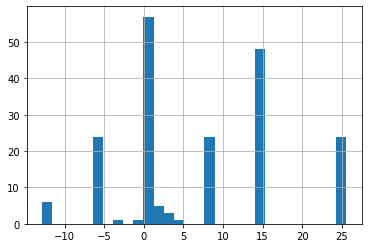

In [9]:
(sampled_pressures - explicit_pressures).hist(bins=30)

# NP 2D

In [10]:
model_dir = toolkit_dir / 'matlab_archive' / 'test' / 'fixtures' / 'np2d_cond'
model_root = 'cond'

sampled_config_path = Path('./model_sampled_config.yaml')
sampled_pressures_path = Path('model_sampled.iap')
explicit_pressures_path = model_dir / f'{model_root}.iap'

In [11]:
sampled_config = {
    'hydrostatic_pressure': {
        'model_kind': 'depth',
        'model_params': {
            'z_interval_m': 5,
            'reference_z': 4174.31,
            'reference_pressure_MPa': 45.289,
            'reference_temperature_degC': 2,
        },
        'interpolation_kind': 'regular_grid',
        'interpolation_params': {
            'x_samples': 100,
            'z_samples': 1000,
        },
        'sampling_config': {
#             'explicit_nodes': [1, 2, 3],
            'explicit_material_zones': [1, 2, 3, 4, 5, 6],
#             'explicit_outside_zones': ['top'],
        },
    }
}
with open(sampled_config_path, 'w') as f:
    yaml.dump(sampled_config, f, Dumper=yaml.Dumper)

In [12]:
generate_hydrostatic_pressure_file(
    config_file=sampled_config_path,
    fehm_file=model_dir / f'{model_root}.fehm',
    outside_zone_file=model_dir / f'{model_root}_outside.zone',
    material_zone_file=model_dir / f'{model_root}_material.zone',
    restart_file=model_dir / f'{model_root}.fin',
    water_properties_file=water_properties_path,
    output_file=sampled_pressures_path,
)

2022-06-27 16:29:17,453 (INFO) Reading configuration file: model_sampled_config.yaml
2022-06-27 16:29:17,459 (INFO) Reading water properties lookup
2022-06-27 16:29:18,275 (INFO) Reading node data into memory
2022-06-27 16:29:19,786 (INFO) Generating temperature lookups
2022-06-27 16:29:19,799 (INFO) Calculating explicit pressures for 35840/35840 nodes
2022-06-27 16:29:33,489 (INFO) Pressures calculated: 10000 / 35840
2022-06-27 16:29:47,421 (INFO) Pressures calculated: 20000 / 35840
2022-06-27 16:30:02,047 (INFO) Pressures calculated: 30000 / 35840
2022-06-27 16:30:11,980 (INFO) Pressures calculated: 35840 / 35840
2022-06-27 16:30:11,986 (INFO) Sampling with spacing:
    x:     254.55
    z:       4.63
2022-06-27 16:30:11,987 (INFO) Calculating explicit pressures for 100 sampled columns.
2022-06-27 16:30:11,987 (INFO) Pressures calculated:   0%
2022-06-27 16:30:12,033 (INFO) Pressures calculated:  10%
2022-06-27 16:30:12,081 (INFO) Pressures calculated:  20%
2022-06-27 16:30:12,127 (I

In [13]:
grid = read_grid(
    fehm_file=model_dir / f'{model_root}.fehm',
    outside_zone_file=model_dir / f'{model_root}_outside.zone',
    material_zone_file=model_dir / f'{model_root}_material.zone',
    read_elements=False,
)

x, y, z, depth = {}, {}, {}, {}
for node in grid.nodes:
    x[node.number] = node.x
    y[node.number] = node.y
    z[node.number] = node.z
    depth[node.number] = node.depth

single_material_zone = {
    node_number: zone.number
    for zone in grid.material_zones
    for node_number in zone.data
}
single_outside_zone = {
    node_number: zone.name
    for zone in grid.outside_zones
    for node_number in zone.data
}

df = pd.DataFrame(data={
    'x': x,
    'y': y,
    'z': z,
    'depth': depth,
    'material_zone': single_material_zone,
    'outside_zone': single_outside_zone,
    'explicit_pressures': {n: p for n, p in enumerate(read_pressure(explicit_pressures_path), start=1)},
    'sampled_pressures': {n: p for n, p in enumerate(read_pressure(sampled_pressures_path), start=1)},
})

df['explicit_pressures'] = df.explicit_pressures * 1000 # kPa
df['sampled_pressures'] = df.sampled_pressures * 1000 # kPa
df['pressure_diff'] = df.sampled_pressures - df.explicit_pressures

<AxesSubplot:>

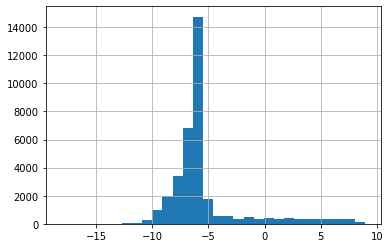

In [14]:
df.pressure_diff.hist(bins=30)

# JdF 3D

In [15]:
model_dir = toolkit_dir / 'matlab_archive' / 'test' / 'fixtures' / 'jdf3d_conduit_p12'
model_root = 'p12'

sampled_config_path = Path('./model_sampled_config.yaml')
sampled_pressures_path = Path('model_sampled.iap')
explicit_pressures_path = model_dir / f'{model_root}.iap'

In [16]:
sampled_config = {
    'hydrostatic_pressure': {
        'model_kind': 'depth',
        'model_params': {
            'z_interval_m': 5,
            'reference_z': 4450,
            'reference_pressure_MPa': 25,
            'reference_temperature_degC': 2,
        },
        'interpolation_kind': 'regular_grid',
        'interpolation_params': {
            'x_samples': 80,
            'y_samples': 160,
            'z_samples': 500,
        },
        'sampling_config': {
#             'explicit_nodes': [1, 2, 3],
            'explicit_outside_zones': ['top'],
        },
    }
}
with open(sampled_config_path, 'w') as f:
    yaml.dump(sampled_config, f, Dumper=yaml.Dumper)

In [17]:
generate_hydrostatic_pressure_file(
    config_file=sampled_config_path,
    fehm_file=model_dir / f'{model_root}.fehm',
    outside_zone_file=model_dir / f'{model_root}_outside.zone',
    material_zone_file=model_dir / f'{model_root}_material.zone',
    restart_file=model_dir / f'cond.fin', # using cond
    water_properties_file=water_properties_path,
    output_file=sampled_pressures_path,
)

2022-06-27 16:30:14,236 (INFO) Reading configuration file: model_sampled_config.yaml
2022-06-27 16:30:14,240 (INFO) Reading water properties lookup
2022-06-27 16:30:14,997 (INFO) Reading node data into memory
2022-06-27 16:30:22,367 (INFO) Generating temperature lookups
2022-06-27 16:30:22,492 (INFO) Calculating explicit pressures for 29453/396508 nodes
2022-06-27 16:30:30,855 (INFO) Pressures calculated: 10000 / 29453
2022-06-27 16:30:39,021 (INFO) Pressures calculated: 20000 / 29453
2022-06-27 16:30:46,783 (INFO) Pressures calculated: 29453 / 29453
2022-06-27 16:30:46,795 (INFO) Sampling with spacing:
    x:    1012.66
    y:     817.61
    z:       9.02
2022-06-27 16:30:46,796 (INFO) Calculating explicit pressures for 12800 sampled columns.
2022-06-27 16:30:46,797 (INFO) Pressures calculated:   0%
2022-06-27 16:30:52,898 (INFO) Pressures calculated:  12%
2022-06-27 16:30:58,976 (INFO) Pressures calculated:  25%
2022-06-27 16:31:04,964 (INFO) Pressures calculated:  38%
2022-06-27 16:

### Compare model pressures

In [18]:
grid = read_grid(
    fehm_file=model_dir / f'{model_root}.fehm',
    outside_zone_file=model_dir / f'{model_root}_outside.zone',
    material_zone_file=model_dir / f'{model_root}_material.zone',
    read_elements=False,
)

x, y, z, depth = {}, {}, {}, {}
for node in grid.nodes:
    x[node.number] = node.x
    y[node.number] = node.y
    z[node.number] = node.z
    depth[node.number] = node.depth

single_material_zone = {
    node_number: zone.number
    for zone in grid.material_zones
    for node_number in zone.data
}
single_outside_zone = {
    node_number: zone.name
    for zone in grid.outside_zones
    for node_number in zone.data
}

df = pd.DataFrame(data={
    'x': x,
    'y': y,
    'z': z,
    'depth': depth,
    'material_zone': single_material_zone,
    'outside_zone': single_outside_zone,
    'explicit_pressures': {n: p for n, p in enumerate(read_pressure(explicit_pressures_path), start=1)},
    'sampled_pressures': {n: p for n, p in enumerate(read_pressure(sampled_pressures_path), start=1)},
})

df['explicit_pressures'] = df.explicit_pressures * 1000 # kPa
df['sampled_pressures'] = df.sampled_pressures * 1000 # kPa
df['pressure_diff'] = df.sampled_pressures - df.explicit_pressures

<AxesSubplot:>

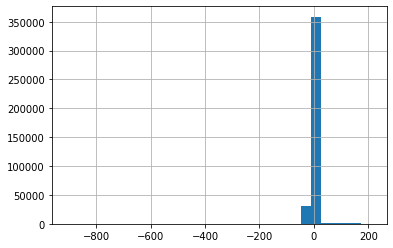

In [19]:
df.pressure_diff.hist(bins=30)

<AxesSubplot:>

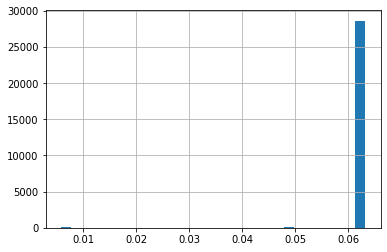

In [20]:
df[df.outside_zone == 'top'].pressure_diff.hist(bins=30)

<AxesSubplot:>

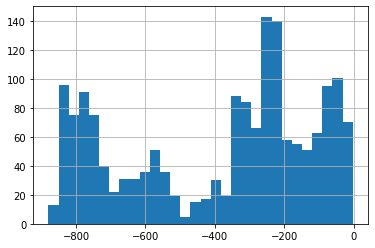

In [21]:
df[df.outside_zone == 'bottom'].pressure_diff.hist(bins=30)

<AxesSubplot:>

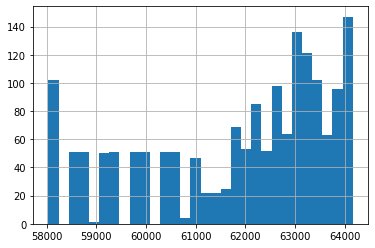

In [22]:
df[df.outside_zone == 'bottom'].sampled_pressures.hist(bins=30)